Convert JSON to CSV

In [ ]:
# Since google restaurant dataset is in json format, use pandas to convert it into a CSV file
# DO NOT RERUN
import pandas as pd 
df = pd.read_json(r'E:\AIEBA Datasets\Proj1 Datasets\GoogleRestaurantReview.json', lines=True)
df.to_csv(r'E:\AIEBA Datasets\Proj1 Datasets\GoogleRestaurantReview.csv', index = None)

Formatting of Data

In [6]:
# Load in all three datasets
# .csv files use the utf-8 encoding
import pandas as pd

#amzn = pd.read_csv(r'E:\AIEBA Datasets\Proj1 Datasets\AmazonReviews.csv',encoding='utf-8',engine='python')
#googl = pd.read_csv(r'E:\AIEBA Datasets\Proj1 Datasets\GoogleRestaurantReview.csv',encoding='utf-8',engine='python')
#dis = pd.read_csv(r'E:\AIEBA Datasets\Proj1 Datasets\DisneylandReviews.csv',encoding='utf-8',engine='python')

amzn = pd.read_csv(r'C:\AIEBA Datasets\Proj1 Datasets\AmazonReviews.csv',encoding='utf-8',engine='python')
googl = pd.read_csv(r'C:\AIEBA Datasets\Proj1 Datasets\GoogleRestaurantReview.csv',encoding='utf-8',engine='python')
dis = pd.read_csv(r'C:\AIEBA Datasets\Proj1 Datasets\DisneylandReviews.csv',encoding='utf-8',engine='python')

In [ ]:
amzn.head()

In [ ]:
googl.head()

In [ ]:
dis.head()

In [7]:
# Drop columns that are not needed and standardize column names
amzn = amzn.filter(items=['reviews.rating', 'reviews.text'])
amzn = amzn.rename(columns={"reviews.rating":"reviews_rating", "reviews.text":"reviews_text"})

googl = googl.filter(items=['rating', 'review_text'])
googl = googl.rename(columns={"rating":"reviews_rating", "review_text":"reviews_text"})

dis = dis.filter(items=['Rating','Review_Text'])
dis = dis.rename(columns={"Rating":"reviews_rating", "Review_Text":"reviews_text"})

amzn.head()

,reviews_rating,reviews_text
0,5.0,This $product so far has not%&^# disappointed....
1,5.0,great for beginner or experienced person. Boug...
2,5.0,Inexpensive tablet for him to use and learn on...
3,4.0,I've had my Fire HD 8 two weeks now and I love...
4,5.0,I bought this for my grand daughter when she c...


In [8]:
# Concatenate all 3 datasets by column
combined = pd.concat([amzn, googl, dis], ignore_index=True)
combined

,reviews_rating,reviews_text
0,5.0,This $product so far has not%&^# disappointed....
1,5.0,great for beginner or experienced person. Boug...
2,5.0,Inexpensive tablet for him to use and learn on...
3,4.0,I've had my Fire HD 8 two weeks now and I love...
4,5.0,I bought this for my grand daughter when she c...
...,...,...
1125886,5.0,i went to disneyland paris in july 03 and thou...
1125887,5.0,2 adults and 1 child of 11 visited Disneyland ...
1125888,5.0,My eleven year old daughter and myself went to...
1125889,4.0,"This hotel, part of the Disneyland Paris compl..."


Data Cleansing and preprocessing

In [9]:
# remove rows with missing values
print(combined.isnull().sum())
combined = combined.dropna()


reviews_rating    55
reviews_text      16
dtype: int64


In [ ]:
#missing values removed 
print(combined.isnull().sum())

In [10]:
# remove non alphanumeric values from reviews_text data rows while preserving whitespace
import re 

cleanup_re = re.compile('[^\w\s\.\,\!\?\']') # match whitespaces, words and puctuations
def cleanup(sentence):
  sentence = str(sentence)
  sentence = cleanup_re.sub('',sentence).strip() # remove anything that is not within the match
  return sentence

combined["reviews_text"] = combined["reviews_text"].apply(cleanup)
  

C:\Users\czy20\AppData\Local\Temp\ipykernel_14500\3888776997.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined["reviews_text"] = combined["reviews_text"].apply(cleanup)


In [ ]:
combined.head()

In [ ]:
combined["reviews_rating"].value_counts().plot.bar()
combined["reviews_rating"].value_counts(ascending=True)

5.0    30092
4.0    30092
3.0    30092
2.0    30092
1.0    30092
Name: reviews_rating, dtype: int64

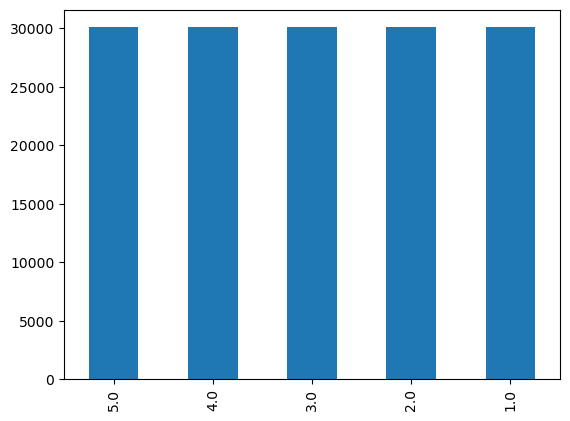

In [11]:
least_class_amount, class_1, class_3, class_4, class_5 = combined.reviews_rating.value_counts(ascending=True)

# create separate dataframes for each rating
c5 = combined[combined["reviews_rating"] == 5.0]
c4 = combined[combined["reviews_rating"] == 4.0]
c3 = combined[combined["reviews_rating"] == 3.0]
c2 = combined[combined["reviews_rating"] == 2.0]
c1 = combined[combined["reviews_rating"] == 1.0]

# randomly remove data to in each dataframe to match the number of rows in c2 which has the least amount of data
df_5 = c5.sample(least_class_amount, random_state=100)
df_4 = c4.sample(least_class_amount, random_state=100)
df_3 = c3.sample(least_class_amount, random_state=100)
df_1 = c1.sample(least_class_amount, random_state=100)

# concatenate all 5 dataframes into 1 to get a balanced dataset
undersampled = pd.concat([df_5, df_4, df_3, c2, df_1], axis=0)
combined = undersampled
combined.reviews_rating.value_counts().plot.bar()
combined.reviews_rating.value_counts()

In [12]:
# perform 80-20 split on data
from sklearn.model_selection import train_test_split
train, test = train_test_split(combined, test_size=0.2, train_size=0.8, random_state=100) 
# random_state controls how data is being shuffled
# ensures that data is being shuffled the same way every time the cell is being ran


In [24]:
train.head()

,reviews_rating,reviews_text
1020326,1.0,Horrible rude service...... Sat here for 10 m...
810795,1.0,Sonic supposed to be fast. This location is th...
1012916,5.0,Great brunch place with a view.
693067,1.0,Super duper slow and the app sucks to. TRIGGERED
122049,3.0,Customer service was excellent. Tacos where a ...


Constructing the model

In [37]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

training_sentences = train["reviews_text"]
training_labels = train["reviews_rating"]
test_sentences = test["reviews_text"]
test_labels = test["reviews_rating"]
vocab_size = 48000 # number of words that will be fed into model 
max_length = 100 #
trunc_type='post' # 
padding_type='post' #
oov_tok = "<OOV>" # placeholder if model encounters words it has never seen before in the test set

# Tokenization - breaking down sentences into its individual words and assigning a number to it
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index # Model's 'vocabulary' learnt from training data

# Sequencing - converting each sentence into its numerical equivalent
# Padding and truncating used to make all sentences same length 
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type,
                               truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type,
                               truncating=trunc_type)
            

546743    3.0
531336    5.0
604194    4.0
403332    5.0
78741     5.0
         ... 
171150    1.0
61613     5.0
32761     4.0
971662    2.0
74374     3.0
Name: reviews_rating, Length: 30092, dtype: float64

In [20]:
tokenizer.word_docs

defaultdict(int,
            {'be': 24157,
             'wont': 425,
             'us': 9571,
             'ready': 1514,
             'mins': 1426,
             'horrible': 2655,
             'to': 62918,
             'said': 5846,
             'and': 85035,
             'again': 8546,
             'rude': 2547,
             'finally': 2217,
             'back': 15412,
             'are': 23035,
             'sat': 2241,
             'came': 9258,
             'never': 8026,
             'you': 25970,
             'here': 15690,
             'ever': 5718,
             'then': 7582,
             'service': 29021,
             'up': 13321,
             'even': 11603,
             '10': 4137,
             'she': 6808,
             'for': 50503,
             'waitress': 4847,
             'a': 68485,
             'had': 28913,
             'simple': 1049,
             'just': 19180,
             'mad': 263,
             'supposed': 1311,
             'proper': 260,
             'is': 4713

In [ ]:
tokenizer.word_counts

In [38]:
# Need this block to get it to work with TensorFlow 2.x
training_padded = np.array(training_padded)
training_labels = tf.keras.utils.to_categorical(training_labels)
test_padded = np.array(test_padded)
test_labels = tf.keras.utils.to_categorical(test_labels)


array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

Model Building

In [39]:
num_of_ratings = 6 # number of class is 5, but +1 due to one hot encoding
embedding_dim = 32
# Crating a model with 3 fully connected layers:
# 1 embedding layer to find correlation between words, 1 pooling layer, 1 layer with relu function 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'), 
    tf.keras.layers.Dense(num_of_ratings, activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           1536000   
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                792       
                                                                 
 dense_3 (Dense)             (None, 6)                 150       
                                                                 
Total params: 1,536,942
Trainable params: 1,536,942
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Training model

epochs_2 = 10
#history = model.fit(training_padded, training_labels, epochs=epochs_2, validation_data=(test_padded, test_labels), verbose=2)
history = model.fit(training_padded, training_labels, epochs=epochs_2)

Epoch 1/10
3762/3762 [==============================] - 62s 16ms/step - loss: 1.1726 - accuracy: 0.4818
Epoch 2/10
3762/3762 [==============================] - 54s 14ms/step - loss: 0.9778 - accuracy: 0.5723
Epoch 3/10
3762/3762 [==============================] - 53s 14ms/step - loss: 0.9303 - accuracy: 0.5972
Epoch 4/10
3762/3762 [==============================] - 53s 14ms/step - loss: 0.8965 - accuracy: 0.6145
Epoch 5/10
3762/3762 [==============================] - 56s 15ms/step - loss: 0.8659 - accuracy: 0.6313
Epoch 6/10
3762/3762 [==============================] - 54s 14ms/step - loss: 0.8362 - accuracy: 0.6483
Epoch 7/10
3762/3762 [==============================] - 54s 14ms/step - loss: 0.8062 - accuracy: 0.6643
Epoch 8/10
3762/3762 [==============================] - 53s 14ms/step - loss: 0.7769 - accuracy: 0.6802
Epoch 9/10
3762/3762 [==============================] - 54s 14ms/step - loss: 0.7482 - accuracy: 0.6936
Epoch 10/10
3762/3762 [==============================] - 54s 14m

In [60]:
# Predicting with model
pred_prob = model.predict(test_padded)

941/941 [==============================] - 2s 2ms/step


In [64]:
# Generating confusion matrix based on predictions 
# True is column, Pred is row 
pred = np.argmax(pred_prob, axis=1)
true = np.argmax(test_labels, axis=1)
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(true, pred, labels=[5,4,3,2,1])
print(confusion_m)

[[3846 1727  260  109   70]
 [1448 3077 1083  306  107]
 [ 284 1256 2587 1432  358]
 [ 100  295 1304 2907 1468]
 [  92  126  365 1749 3736]]


In [53]:
sentence = ["this place was a 10/10 experience", "this was horrible"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
output= model.predict(padded)

print(output)
print("Review:", sentence)
print("Rating:", np.argmax(output, axis=1, out=None))


1/1 [==============================] - 0s 38ms/step
[[0.16728865 0.1610855  0.17166638 0.16348098 0.17632394 0.1601545 ]
 [0.16728973 0.1608288  0.17187664 0.16343455 0.17689063 0.1596796 ]]
Review: ['this place was a 10/10 experience', 'this was horrible']
Rating: [4 4]


array([[2]], dtype=int64)